## Case study of SARSA($\lambda$) in the tabular case

In this assignment, I will go through the SARSA($\lambda$) with eligibility traces algorithm with its theoretical background and also show its performance in a tabular environment.

### Background

Let's first put ourselves in a situation where we wish to do iterative control over a policy, i.e. we want to improve it while we evaluate it. Let's further consider the two algorithms on both sides of the spectrum of reinforcement learning algorithms.


#### Monte Carlo

The Monte Carlo algorithm is one of the simplest to implement and one that is without bias when we consider the expected action-values that are obtained.

Indeed, this methods only uses pure experience in order to modify the values of the state-action pairs visited according to the following update rule for a given state $s_t$ visited and action $a_t$ taken at time step $t$.

$Q(s_t, a_t) \leftarrow Q(s_t, a_t) + \alpha(G_t - Q(s_t, a_t))$, where $G_t$ represents the total discounted return following time step $t$ according to the episode.

In other words, we experience an episode, at the end we look how each trajectory visited returned. Then, according to how much more it generated compared to what we expected, we adjust our previous estimate.

Here is a figure showing the unrolling of an episode before a back-up is made.
<img src='mc_backup_tree.png'>

A circle represents a state actually visited, a dot an action that led to the following state and the grey square the terminal state in which the episode terminated.

One of the known disadvantage of Monte Carlo method is that using only pure experience causes high variance in terms of the observed returns. The rollout of an episode can be seen as a tree that is growing in width as time goes on when we consider the possible paths the agent could have taken. The MC algorithm picks just the one observed and makes it a basis for updating our values.


#### Sarsa(0)

On the other end of the spectrum, we have the Sarsa(0) algorithm. It's main objective is to counter the variance in the MC algorithm, by limiting the lenght of the trajectory for the update to one. In MC we used all the trajectory until the end of the episode, but under Sarsa(0) we will only consider the *one step* return.

However, we still need an estimate of the upcoming total return once we have taken that *one step*. To do so, this algorithm introduces bootstrapping, which consists of using your own estimate of the upcoming total return as a way to update the current value. The update rule is therefore,

$Q(s_t, a_t) \leftarrow Q(s_t, a_t) + \alpha(R_t + \gamma Q(s_{t+1}, a_{t+1}) - Q(s_t, a_t))$, where $R_t$ represents the reward observed at time $t$ and $\gamma$ the discount rate.

In comparison to the previous MC backup tree showed previously, here is the one for Sarsa(0).
<img src='sarsa_0_backup_tree.png'>

One other major advantage of this method is it can be implemented in an online fashion, as we don't need to wait until the end of the episode to update our values, making it more *ressource friendly*.

### Sarsa($\lambda$) - the middle ground

We now have two methods that stand on each end of a spectrum, MC that uses the full observed sequences, and Sarsa(0) that uses only one step observations. The next logical thing to consider is somewhere in the middle, where we get to see a couple observations before we use our estimate to update the action-state values. This concept is called *n-step returns*.

However, the question still comes up regarding how long should we look in the future before updating. This is why Sarsa($\lambda$) comes into play.

This algorithm will let us consider all the possible horizons for updating our values. It introduces a parameter $\lambda$ that will control how much importance we attribute to a longer/shorter horizon. 

There are two approaches to this algorithm,

- the forward-view approach using $\lambda$-return
- the backward-view approach using eligibility traces

In this case study, I will only be exploring the eligibility traces approach that allows for an online implementation. 

It is important to point out though that both of these approaches do not yield precisely the same total updates once online updates are incorporated. Having $\lambda = 0$ does the same upates as Sarsa(0), it is by having $\lambda > 0$ that we do not get the same updates as the forward view. However, with the latter and $\lambda = 1$, we do get conceptually something analogous to MC that considers a long horizon.


#### What is an eligibility trace?

We need a way to be able to give importance to all previous observations that were made during an episode, but by allowing flexibility to how much importance we give it.

At any given time step during an episode, we will update all the value of all possible state-action pairs based on the observed one-step TD error $ \delta_t = R_t + Q(s_{t+1}, a_{t+1}) - Q(s_t, a_t)$. However, some of these pairs are surely more responsible than others for that observed TD error $\delta_t$. Indeed, one can conceive that logically, the actions and states visited should have an impact based on how often and how recently they were occured.

The eligibility trace is exactly the mechanism that will consider both the frequency and timing of a state-action pair in order to make the online updates.


#### Using eligibility traces to update Q-values

The best way to understand it, is by going through conceptually what the algorithm will be doing.

We first need to set up an eligibility trace for each state action pair and set it to 0. To account for the frequency of an occurence of a state-action pair by the agent, when a given pair is *visited/taken*, we increase it's eligibility trace by 1. To account for the timing of the *visit* of a state action pair, at each time step that is non-terminal, all the egibility traces are decayed by the parameter $\lambda$.

When it is time to update the Q-values, we determine the TD error for that step, and then we go through all the state action pairs. We factor the error by the value of the eligibility trace for all pairs and then apply update the Q-values.

In other words, if a pair wasn't visited in that episode yet, then it's eligibility trace will be 0 and won't be updated. If it just recently got visited, then it will have a high eligibility trace and therefore will receive a high update w.r.t. the TD error. If $\lambda = 0$, none of the previous eligibility traces ak kept, making this the one-step updates of Sarsa(0).

Furthermore, this can be efficiently implemented by using element-wise operations on and between Q-value and eligibility traces matrices!

Here is a figure showing the full algorithm (from David Silver's RL course slides),
<img src='eligib_trace_tabular.png'>

### Performance

In this section I will apply the Sarsa($\lambda$) algorithm with eligibility traces on the Frozen-Lake environment by Open AI and see the effect of varying the parameter $\lambda$. More details about this environment can be found [here](https://gym.openai.com/envs/FrozenLake-v0).

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import gym
import pandas
import pickle as pkl
import itertools

In [2]:
env = []
env.append(gym.make('FrozenLake-v0')) # Used for Regular Q-Learning
print 'Regular Q-Learning'
env[0].render()

[2017-04-05 20:16:37,017] Making new env: FrozenLake-v0


Regular Q-Learning
SFFF
FHFH
FFFH
HFFG



In [3]:
nb_states = env[0].observation_space.n
nb_actions = env[0].action_space.n

# Settings for learning
nb_episodes = 25000
eps_init = 0.2
lr_init = 0.2
gamma = 0.99
lmbdas = [1.0, 0.99, 0.95, 0.9, 0.8, 0.75, 0.6, 0.4, 0.25, 0.15, 0.05, 0.0]

In [4]:
nb_runs = 20
ep_rwrds = np.zeros((nb_runs, len(lmbdas), nb_episodes))
for run in xrange(nb_runs):
    for i, lmbda in enumerate(lmbdas):
        lr = lr_init
        eps = eps_init
        Q = np.zeros((nb_states, nb_actions)) # Q-values
        for n in xrange(nb_episodes):

            # initialize the eligibility traces
            E = np.zeros((nb_states, nb_actions))

            # reset params for the episode
            steps = 1
            tot_rwrd = 0
            done = False

            # reset the environment
            prev_state = env[0].reset()

            if np.random.random_sample() <= eps:
                # choose action at random
                prev_action = env[0].action_space.sample()
            else:
                # choose greedy action
                prev_action = np.argmax(Q[prev_state, :])

            # loop until end of episode
            while not done:

                # get new_state, reward for action and if reached the goal
                new_state, rwrd, done, _ = env[0].step(prev_action)

                if np.random.random_sample() <= eps:
                    # choose action at random
                    new_action = env[0].action_space.sample()
                else:
                    # choose greedy action
                    new_action = np.argmax(Q[new_state, :])

                # Get error and update eligibility trace
                error = rwrd + gamma * Q[new_state, new_action] - Q[prev_state, prev_action]
                E[prev_state, prev_action] = E[prev_state, prev_action] + 1.0

                # Update all Q-values and Eligibility traces
                Q += lr * error * E
                E *= lmbda

                prev_state = new_state
                prev_action = new_action
                tot_rwrd += rwrd
                steps += 1

            # Store results
            ep_rwrds[run, i, n] = tot_rwrd

            if n % (nb_episodes / 10) == 0:
                print 'run %s -- lmbda %s -- ep %s -- lr %s -- eps %s' %(run + 1, lmbda, n, lr, eps)

run 1 -- lmbda 1.0 -- ep 0 -- lr 0.2 -- eps 0.2
run 1 -- lmbda 1.0 -- ep 2500 -- lr 0.2 -- eps 0.2
run 1 -- lmbda 1.0 -- ep 5000 -- lr 0.2 -- eps 0.2
run 1 -- lmbda 1.0 -- ep 7500 -- lr 0.2 -- eps 0.2
run 1 -- lmbda 1.0 -- ep 10000 -- lr 0.2 -- eps 0.2
run 1 -- lmbda 1.0 -- ep 12500 -- lr 0.2 -- eps 0.2
run 1 -- lmbda 1.0 -- ep 15000 -- lr 0.2 -- eps 0.2
run 1 -- lmbda 1.0 -- ep 17500 -- lr 0.2 -- eps 0.2
run 1 -- lmbda 1.0 -- ep 20000 -- lr 0.2 -- eps 0.2
run 1 -- lmbda 1.0 -- ep 22500 -- lr 0.2 -- eps 0.2
run 1 -- lmbda 0.99 -- ep 0 -- lr 0.2 -- eps 0.2
run 1 -- lmbda 0.99 -- ep 2500 -- lr 0.2 -- eps 0.2
run 1 -- lmbda 0.99 -- ep 5000 -- lr 0.2 -- eps 0.2
run 1 -- lmbda 0.99 -- ep 7500 -- lr 0.2 -- eps 0.2
run 1 -- lmbda 0.99 -- ep 10000 -- lr 0.2 -- eps 0.2
run 1 -- lmbda 0.99 -- ep 12500 -- lr 0.2 -- eps 0.2
run 1 -- lmbda 0.99 -- ep 15000 -- lr 0.2 -- eps 0.2
run 1 -- lmbda 0.99 -- ep 17500 -- lr 0.2 -- eps 0.2
run 1 -- lmbda 0.99 -- ep 20000 -- lr 0.2 -- eps 0.2
run 1 -- lmbda 0.

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:10: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version


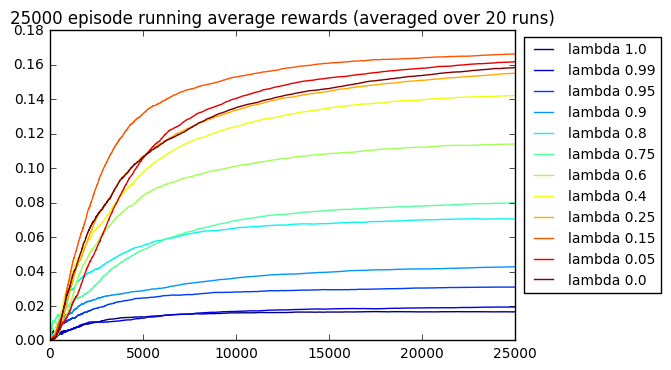

In [5]:
x = xrange(nb_episodes)
avg_size = nb_episodes

avg_ep_rwrds = np.average(ep_rwrds, axis=0)

plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.jet(np.linspace(0, 1, len(lmbdas)))))

for i, result in enumerate(avg_ep_rwrds):

    y = pandas.rolling_mean(result, avg_size, min_periods=1)
    plt.plot(x, y, label='lambda %s' % lmbdas[i])

plt.title('%s episode running average rewards (averaged over %s runs)' %(avg_size, nb_runs))

ymin, ymax = plt.ylim()
# plt.ylim((-4, -1.5))
plt.legend(prop={'size':10}, bbox_to_anchor=(1.33, 1.0))
plt.show()

### Observations

With the above results, we can notice the wide range of performance for a given exploration and learning rate based on multiple values of lambda for the first 25,000 episodes. To allow for a more accurate measure, each setting was run 20 times. The plot shows the running average of episode rewards averaged over these 20 runs.

We can notice the least performing setting at $\lambda = 1$ (darkest blue). This can be explained by the high variance previously mentioned. It makes the longer time horizon less effective under the given configuration.

We can also notice the performance of the configuration with $\lambda = 0$ (brown line), which is pure one-step updates. It seems to be performing well, in particular compared to the much longer horizon. This is a consequence of applying bootstrapping to increase the effectiveness of the learning, which is its main goal!

As initially presented, our intuition is confirmed where in the middle between $\lambda = 0$ and $1$, we find the configuration with $\lambda = 0.15$ which is performing better than the others. We can conclude that to perform better at this task, we need a time horizon that is close to one-step updates, but with some consideration of longer time horizon.

Another aspect to consider is that in a complete implementation, a full hyper parameter search would need to be done w.r.t. $\lambda$, the learning rate and the exploration. Not all configurations have the same performance under other configurations. However, in practice, there seems to always be a $\lambda$ between 0 and 1 that better performs.